In [8]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0,0)), 'constant', constant_values = 0)
    return X_pad

x.shape =  (4, 3, 3, 3)
x_pad.shape =  (4, 7, 7, 3)
x[1,1] =  [[-1.11731035  0.2344157   1.65980218]
 [ 0.74204416 -0.19183555 -0.88762896]
 [-0.74715829  1.6924546   0.05080775]]
x_pad[1,1] =  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


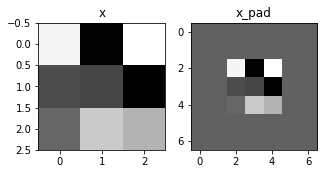

In [17]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 3)
x_pad = zero_pad(x, 2)

print("x.shape = ", x.shape)
print("x_pad.shape = ", x_pad.shape)
print("x[1,1] = ", x[1,1])
print("x_pad[1,1] = ", x_pad[1,1])

fig, axarr = plt.subplots(1,2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [18]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W) + b
    Z = np.sum(s)
    return Z

In [19]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z = ", Z)

Z =  -23.16021220252078


In [24]:
def conv_forward(A_prev, W, b, hparameters):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [26]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad": 2,
              "stride": 1}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's shape = ", Z.shape)
print("Z's mean = ", np.mean(Z))
print("cache_conv[0][1][2][3] = ", cache_conv[0][1][2][3])

Z's shape =  (10, 7, 7, 8)
Z's mean =  0.15585932488906465
cache_conv[0][1][2][3] =  [-0.20075807  0.18656139  0.41005165]


In [27]:
def pool_forward(A_prev, hparameters, mode = "max"):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev  - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
        
    cache = (A_prev, hparameters)
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [33]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1,
              "f" : 4}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A = ", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A = ", A)

mode = max
A =  [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A =  [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]
